# Tensorflow emotion detector

I found a tutorial on Coursera (https://www.coursera.org/learn/tweet-emotion-tensorflow/) which I wanted to do however it was in tensorflow (now mostly deprecated and not used in industry -replaced by jax-). This notebook is to learn how to do it.


In [ ]:

import tensorflow  as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import random
from sklearn.metrics import confusion_matrix

def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.18.1


In [91]:
#Load in the dataset
dataset = load_dataset("emotion")


In [92]:
#Separate the data into train,test and validation sets
train_data = dataset["train"]
test_data = dataset["test"]
validation_data = dataset["validation"]

In [93]:
classes = train_data.features["label"].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [94]:
def get_tweets(data):
    """
    Separates the data into tweets and their labels of emotion

    Input:
    data : datasets.arrow_dataset.Dataset

    Output:
    tweets : list
    labels : list
    """
    tweets = [x["text"] for x in data]
    label = [x["label"] for x in data]
    return tweets,label

In [95]:
train_tweets , train_labels = get_tweets(train_data)
train_tweets[0],classes[train_labels[0]]

('i didnt feel humiliated', 'sadness')

In [96]:
from keras.layers import TextVectorization

vectoriser = TextVectorization(
    max_tokens=10000,
    output_mode="int",
    output_sequence_length=100,  # optional
    standardize="lower_and_strip_punctuation",
    split="whitespace"
)

In [97]:
vectoriser.adapt(train_tweets) #tokenising all the tweets
vectoriser([train_tweets[0]]).numpy()


array([[  2, 140,   3, 686,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [98]:
lengths = [len(l.split(" ")) for l in train_tweets]
train_tweets[0] , lengths[0]

('i didnt feel humiliated', 4)

Text(0.5, 1.0, 'Frequency of number of words in sentences')

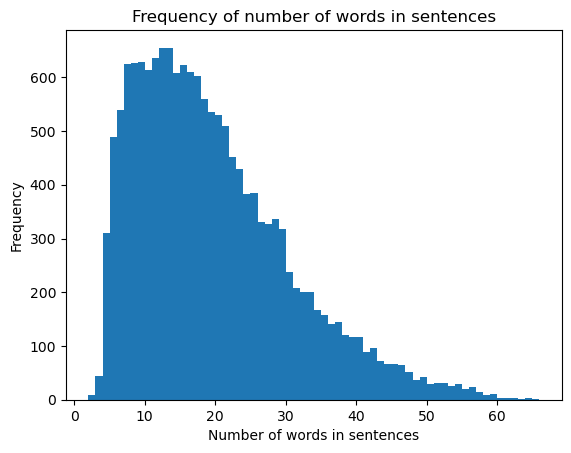

In [99]:
plt.hist(lengths, bins=len(set(lengths)))
plt.ylabel("Frequency")
plt.xlabel("Number of words in sentences")
plt.title("Frequency of number of words in sentences")

In [100]:
from keras.preprocessing.sequence import pad_sequences

In [101]:
maxlen = 50

def get_sequences(tweets, tokenizer):
    sequences = tokenizer(tweets)
    padded_sequences = pad_sequences(sequences,padding="post", truncating="post" ,maxlen=maxlen)
    return padded_sequences

In [102]:
padded_training_seq = get_sequences(train_tweets , vectoriser)
padded_training_seq[0]

array([  2, 140,   3, 686,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [103]:
index_set = set(train_labels)
index_set,classes

({0, 1, 2, 3, 4, 5}, ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [104]:
class_to_index = dict((c,i) for i,c in enumerate(classes))
index_to_class = dict((v, k) for k, v in class_to_index.items())

In [ ]:
class_to_id = lambda labels : np.array([class_to_index.get(x) for x in labels])

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000,16,input_shape=(maxlen,)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation="softmax")
])

model.compile(
    loss = "sparse_categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"]
)


/Users/ammarnagri/miniconda3/envs/emotion_detection/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [107]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 50, 16)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 50, 40)         │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 40)             │         9,760 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │           246 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 175,926 (687.21 KB)

 Trainable params: 175,926 (687.21 KB)

 Non-trainable params: 0 (0.00 B)

In [108]:
validation_tweets , validation_labels = get_tweets(validation_data)
validation_sequences = get_sequences(tokenizer=vectoriser, tweets=validation_tweets)
validation_tweets[0] , validation_labels[0] , index_to_class.get(validation_labels[0])

('im feeling quite sad and sorry for myself but ill snap out of it soon',
 0,
 'sadness')

In [110]:
history = model.fit(
    padded_training_seq,np.array(train_labels),
    validation_data=(validation_sequences,np.array(validation_labels)),
    epochs = 20,
    callbacks = [keras.callbacks.EarlyStopping(monitor="val_accuracy")] 
)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.3745 - loss: 1.5372 - val_accuracy: 0.6740 - val_loss: 0.9056
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.7748 - loss: 0.6603 - val_accuracy: 0.8285 - val_loss: 0.5048
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.8972 - loss: 0.3090 - val_accuracy: 0.8575 - val_loss: 0.4193
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.9281 - loss: 0.2037 - val_accuracy: 0.8535 - val_loss: 0.4422


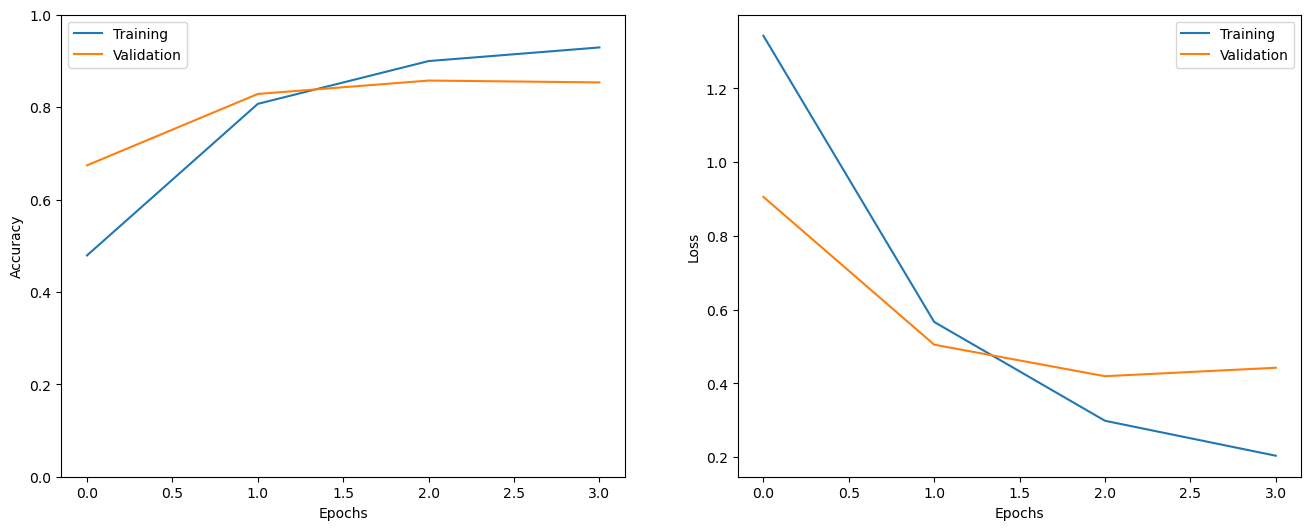

In [111]:
show_history(h=history)

In [113]:
test_tweets , test_labels = get_tweets(test_data)
padded_testing_seq = get_sequences(test_tweets , vectoriser)

In [115]:
_ = model.evaluate(padded_testing_seq,np.array(test_labels))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8758 - loss: 0.4134


In [177]:
index = random.randint(0,len(padded_testing_seq) - 1)
index_to_class.get(np.argmax(model.predict(np.expand_dims(padded_testing_seq[index],axis=0) , verbose=0)[0]).item())
print(f"Sentence : {test_tweets[index]}")
print(f"Sentence : {index_to_class.get(test_labels[index])}")
print(f"Predicted emotion : {index_to_class.get(np.argmax(model.predict(np.expand_dims(padded_testing_seq[index],axis=0) , verbose=0)[0]).item())}")

Sentence : i feel calm and okay but sometimes i just get so sad
Sentence : joy
Predicted emotion : joy


In [194]:
y_pred_probs = model.predict(padded_testing_seq , verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)            
test_labels[0] , y_pred[0]

(0, np.int64(0))

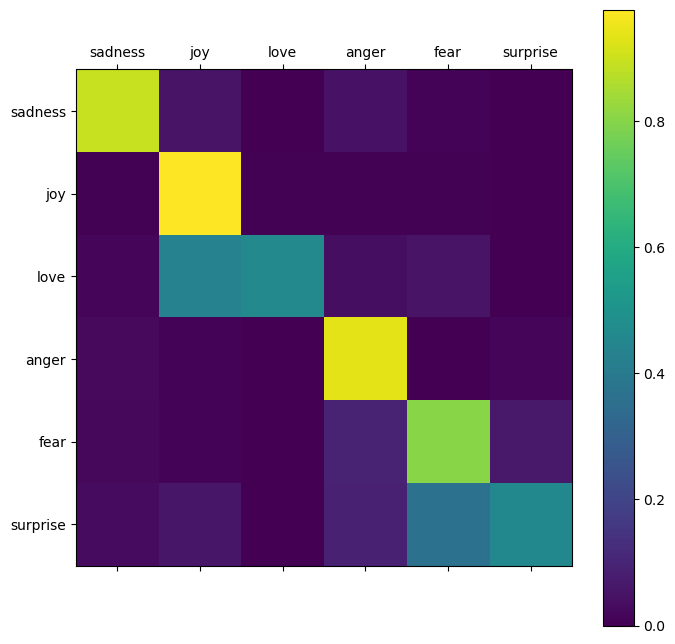

In [195]:
show_confusion_matrix(classes= (classes),y_true=test_labels,y_pred=y_pred)